## Import Packages

In [1]:

# By: Darren Upton
# Modeled on Code By: Kishan Rajput

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import pickle
import seaborn as sns

#Stuff for ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

from keras import backend as K

from matplotlib.colors import LogNorm


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mvyt477p because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def Shower_Clustering(Shower_l, Shower_t, Shower_r, Shower=1):
    #Define Centers
    Shower_Centers = np.array([[-5.28,0.00,5.28], # X
                               [-3.05,6.10,-3.05], # Y
                               [3,3,3]]) #Z
    
    #Shower Modules
    #Adjust Based on MIP for Run
    if Shower==1:
        Shower_MIPs = [37.5,37.5,37.5]
    else:
        Shower_MIPs = [2.8,2.8,2.8]
    Modules = np.column_stack([Shower_l/Shower_MIPs[0], Shower_t/Shower_MIPs[1], Shower_r/Shower_MIPs[2]])
    
    #Calculations
    m_logWeightBase=3.6 #Wighting parameter
    Shower_Sums = Modules.sum(axis=1) #Get shower sum
    
    test_weights = m_logWeightBase + np.log(np.divide((Modules+0.0001), Shower_Sums[:,None], out=np.zeros_like(Modules), where=Shower_Sums[:,None]>0), 
                                            out=np.zeros_like(Modules), where=Shower_Sums[:,None]>0) #Get initial weights in 3-column array
    weights = test_weights*(test_weights > 0) #Check weights by keeping calculated weights > 0, which makes the rest 0
    weight_sums = weights.sum(axis=1) #Sum weights over 3 axes
    
    #Calc Shower Centers
    x = (Shower_Centers[0,:] * weights).sum(axis=1)
    y = (Shower_Centers[1,:] * weights).sum(axis=1)
    #z = (Shower_Centers[2,:] * weights).sum(axis=1)

    #Calc weighted centers
    Sh_x =  np.divide(x, weight_sums, out=np.zeros_like(x)+42, where=weight_sums!=0) + 42*(Shower_Sums==0)
    Sh_y =  np.divide(y, weight_sums, out=np.zeros_like(y)+42, where=weight_sums!=0) + 42*(Shower_Sums==0)
    #Sh_z =  z / weight_sums
    
    return Sh_x, Sh_y#, Sh_z



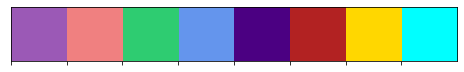

In [3]:
best_colors = ["#9b59b6",
               "lightcoral",
               "#2ecc71","cornflowerblue","indigo",#"darkorange",
               "firebrick","gold",
               "cyan"#"magenta"
              ]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

## Import Data

In [ ]:
%%time 

raw_sim_df = pd.read_csv("Sim_CSV/Sim_Pencil_AllEvents_TID1.csv")
raw_bkg_df = pd.read_csv("Sim_CSV/Sim_Pencil_Bkg.csv")

#Get HE electrons
#sim_df["pid"] = sim_df["pid"]*((sim_df["pid"]!=11) | (sim_df["ShowerSum"]<200))

#sim_df = (raw_sim_df[(raw_sim_df["ShowerSum"]<135*raw_sim_df["p"]) & (raw_sim_df["ShowerSum"]>135*(raw_sim_df["p"]-0.9))]).copy()

#Get Cluster Position
"""Sh_x, Sh_y = Shower_Clustering(raw_sim_df["Shower_l"], raw_sim_df["Shower_t"], raw_sim_df["Shower_r"])
raw_sim_df["Sh_X"] = Sh_x
raw_sim_df["Sh_Y"] = Sh_y

PreSh_x, PreSh_y = Shower_Clustering(raw_sim_df["PreSh_l"], raw_sim_df["PreSh_t"], raw_sim_df["PreSh_r"], Shower=0)
raw_sim_df["PreSh_X"] = PreSh_x
raw_sim_df["PreSh_Y"] = PreSh_y"""

#Get Cher Array
raw_Cher_df = pd.read_csv("Sim_CSV/Sim_Pencil_CherChannels_AllEvents_TID1.csv", 
                          names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
#raw_Cher_df["pid"] = raw_sim_df["pid"]
Cher_df = raw_Cher_df#[(raw_sim_df["PreShSum"]>0)]

sim_df = raw_sim_df#[(raw_sim_df["PreShSum"]>0) & (raw_sim_df["Npesum"]>0)].reset_index(drop=1)#[raw_sim_df["GEM00_Edep"]>35e-6]#[(raw_sim_df["PreShSum"]>0)].reset_index(drop=1)
bkg_df = raw_bkg_df#[GEM00_Edep >35e-6]#[(raw_bkg_df["PreShSum"]>0)&(raw_bkg_df["ShowerSum"]>0)].reset_index(drop=1)
sim_df

In [ ]:
plt.figure(dpi=150)
plt.xlabel("PID")

sns.histplot(sim_df, x=sim_df["pid"].astype(str))#, weights="# rate")

plt.yscale("log")

In [ ]:
plt.figure(dpi=150)
plt.subplot(1,2,1)
sns.histplot(raw_sim_df, x="p", hue="pid", element="step", binwidth=.1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-5]), alpha=0.15, linewidth=0.5)
plt.subplot(1,2,2)
sns.histplot(sim_df, x="p", hue="pid", element="step", binwidth=.1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-5]), alpha=0.15, linewidth=0.5)
plt.tight_layout()

In [ ]:
raw_sim_df.groupby(["pid"]).count().iloc[:,0]

In [ ]:
sim_df.groupby(["pid"]).count().iloc[:,0]

In [ ]:
raw_bkg_df

In [ ]:
sim_df.columns

In [ ]:
# Loop Over Shower Vals
columns =["ShowerSum","PreShSum"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,1500),(0,300)],[(0,1500),(0,300)],[(0,1500),(0,300)],[(0,1500),(0,300)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 50,50,50]

#line_ests = [[[0,100],[100,0]],[[0,120],[130,0]],[[0,130],[120,0]],[[0,130],[120,0]]]

pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e^-$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("PreShowerSum vs ShowerSum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j==3:
        plot_sim = sim_df# & ((sim_df["p"]>3.5) & (sim_df["p"]<3.6))]
    else:
        plot_sim = sim_df[(sim_df["pid"]==part_ids[j])]#

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=bins[j], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,limits[j][0][1],x_bin[j]), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,limits[j][1][1],25), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut


In [ ]:
# Loop Over Shower Vals
columns =["Npesum","NCh"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,1500),(0,250)],[(0,250),(0,100)],[(0,150),(0,100)],[(0,250),(0,100)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 5,5,5]

#line_ests = [[[0,100],[100,0]],[[0,120],[130,0]],[[0,130],[120,0]],[[0,130],[120,0]]]

pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e^-$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("NCh vs Npesum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = sim_df[(sim_df["pid"]==part_ids[j])]
    else:
        plot_sim = sim_df

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=limits[j], 
                                                         #weights=plot_sim["rate"],
                                                         bins=(np.arange(0,201,2.5),np.arange(0,16.1,1)+0.5), 
                                                         norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_yticks(np.arange(0,17,1), minor=1)
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,10), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut
plt.show()


#############################################################

# Loop Over Shower Vals
columns =["Shower_R/ShowerSum","Shower_L/ShowerSum"]
limits = [(0,1250),(0,1250)]#[[(0,1500),(0,250)],[(0,250),(0,100)],[(0,150),(0,100)],[(0,250),(0,100)]] 
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 5,5,5]

pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e^-$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Shower_L vs Shower_R: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = sim_df[(sim_df["pid"]==part_ids[j])]
    else:
        plot_sim = sim_df

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim["Shower_r"], #/plot_sim["ShowerSum"], 
                                                         plot_sim["Shower_l"], #/plot_sim["ShowerSum"], 
                                                         range=limits, 
                                                         #weights=plot_sim["rate"],
                                                         #bins=(np.arange(0,1.1,.01),np.arange(0,1.1,.01)), 
                                                         bins=100,
                                                         norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, 
    #{line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    #axes[int(j/2),j%2].set_xticks(np.arange(0,1.1,.05), minor=1)
    #axes[int(j/2),j%2].set_yticks(np.arange(0,1.1,.05), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut
plt.show()


#############################################################

columns =["PreSh_R/PreShSum","PreSh_L/PreShSum"]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("PreSh_L/PreShSum vs PreSh_R/PreShSum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = sim_df[(sim_df["pid"]==part_ids[j])]
    else:
        plot_sim = sim_df

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim["PreSh_r"]/plot_sim["PreShSum"], 
                                                         plot_sim["PreSh_l"]/plot_sim["PreShSum"], 
                                                         #range=limits[j], 
                                                         #weights=plot_sim["rate"],
                                                         bins=(np.arange(0,1.1,.01),np.arange(0,1.1,.01)), 
                                                         norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, 
    #{line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.1,.05), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.1,.05), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut


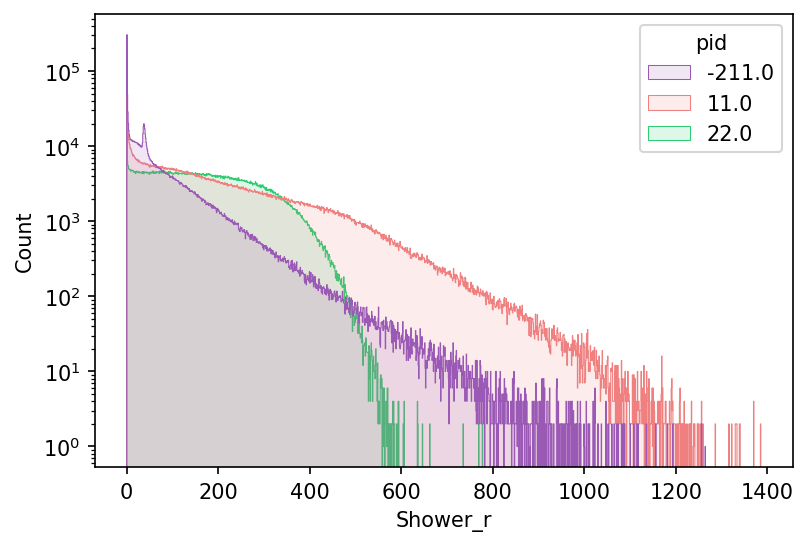

In [16]:
plt.figure(dpi=150)
sns.histplot(sim_df, x=sim_df["Shower_r"], hue="pid", element="step", binwidth=1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-5]), alpha=0.15, linewidth=0.5)

plt.yscale("log")

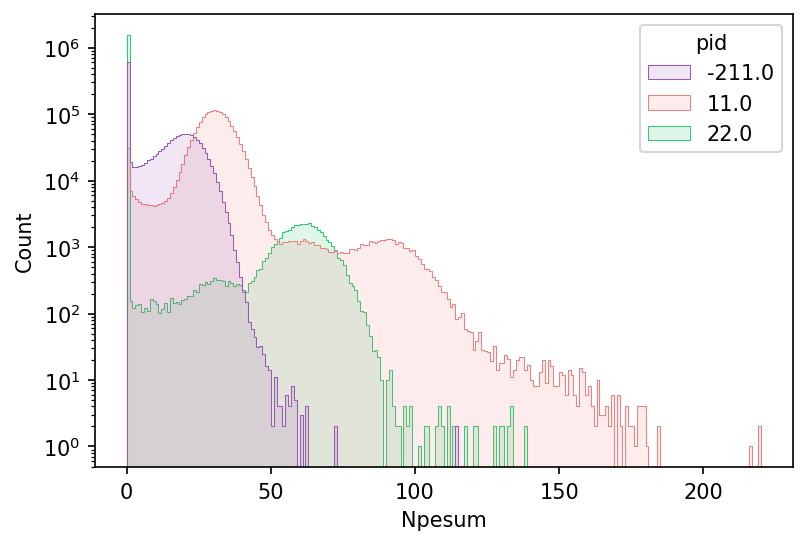

In [17]:
plt.figure(dpi=150)
sns.histplot(sim_df, x="Npesum", hue="pid", element="step", binwidth=1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-5]), alpha=0.15, linewidth=0.5)

#plt.vlines(20, 1, 10**4)

plt.yscale("log")

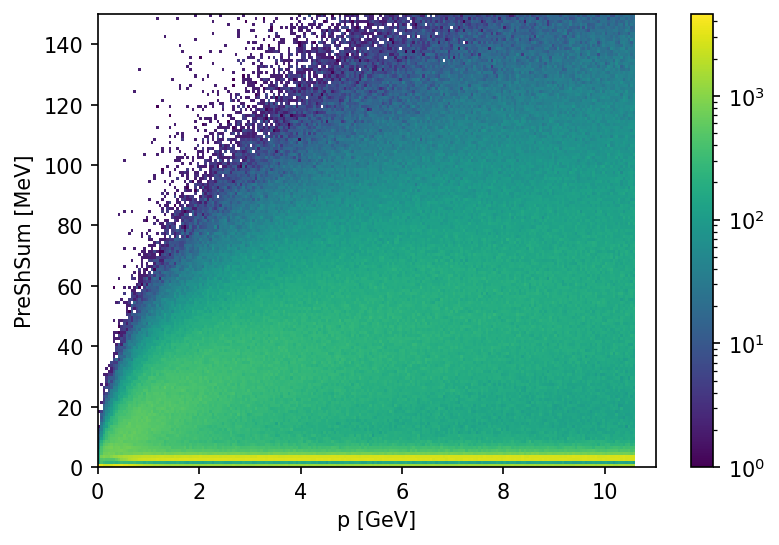

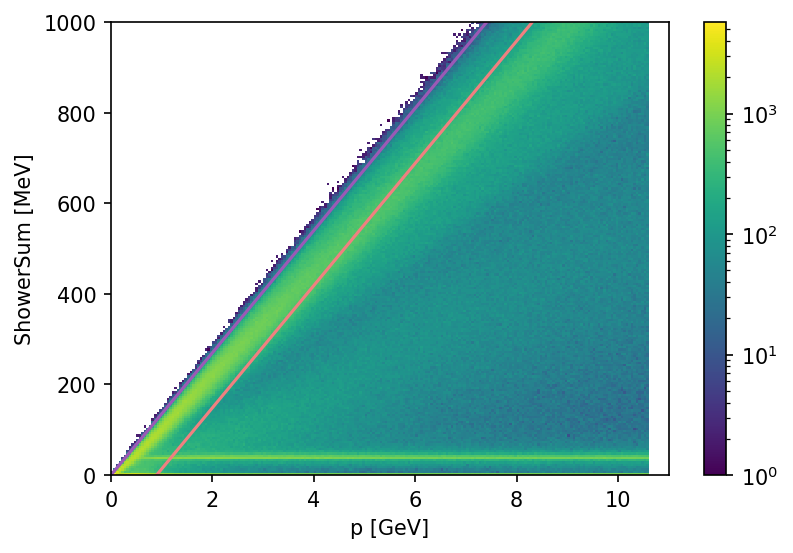

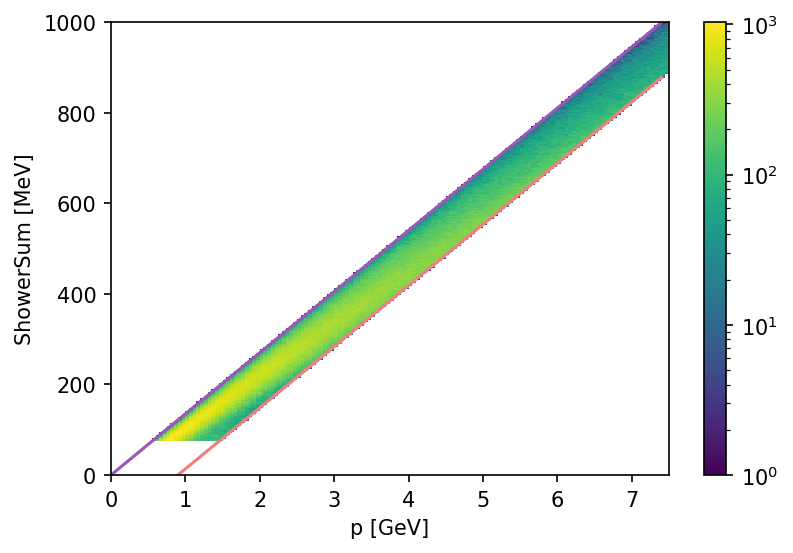

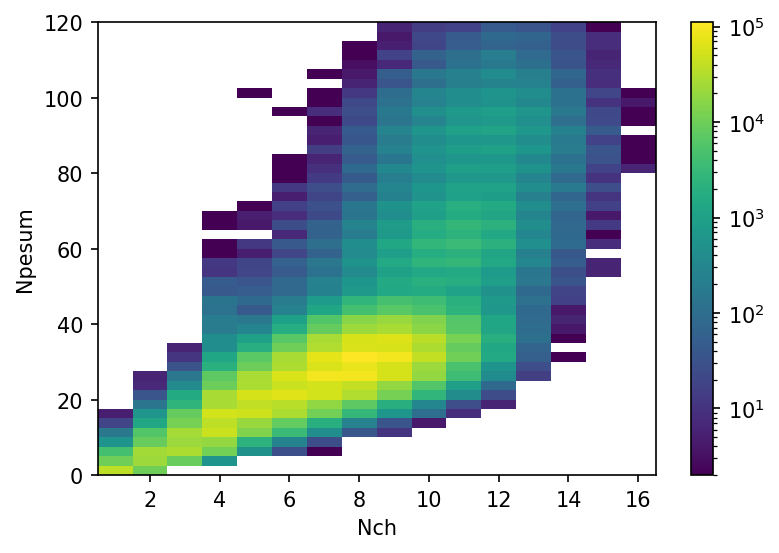

In [18]:
plt.figure(dpi=150)
plt.xlabel("p [GeV]")
plt.ylabel("PreShSum [MeV]")

plt.hist2d(sim_df["p"], sim_df["PreShSum"], bins=(np.arange(0,11.01,.05),np.arange(0,151,1)),norm=LogNorm())

plt.colorbar()
plt.show()

plt.figure(dpi=150)
plt.xlabel("p [GeV]")
plt.ylabel("ShowerSum [MeV]")

plt.hist2d(sim_df["p"], sim_df["ShowerSum"], bins=(np.arange(0,11.01,.05),np.arange(0,1001,5)),norm=LogNorm())

p_vals = np.arange(0,11.5,.1)
plt.plot(p_vals,(p_vals-0*.15)*135)
plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

plt.figure(dpi=150)
plt.xlabel("p [GeV]")
plt.ylabel("ShowerSum [MeV]")

plt.hist2d(sim_df["p"][(sim_df["ShowerSum"]>75) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           sim_df["ShowerSum"][(sim_df["ShowerSum"]>75) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           bins=(np.arange(0,7.51,.05),np.arange(0,1001,2.5)),norm=LogNorm())

p_vals = np.arange(0,7.5,.1)
plt.plot(p_vals,(p_vals-0*.15)*135)
plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

plt.figure(dpi=150)
plt.xlabel("Nch")
plt.ylabel("Npesum")

plt.hist2d(sim_df["NCh"],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           sim_df["Npesum"],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           bins=(np.arange(0,16.1,1)+0.5,np.arange(0,121,2.5)),
           norm=LogNorm())

#p_vals = np.arange(0,7.5,.1)
#plt.plot(p_vals,(p_vals-0*.15)*135)
#plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

In [19]:
(sim_df[(sim_df["ShowerSum"]>75) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))]).groupby(["pid"]).count().iloc[:,0]

pid
-211.0     29338
 11.0     849961
 22.0     477315
Name: # rate, dtype: int64

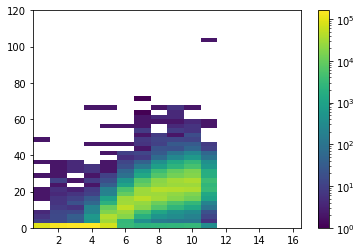

In [112]:
keeps = sim_df["pid"] == -211

plt.hist2d(sim_df["p"][keeps],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           sim_df["Npesum"][keeps],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           bins=(np.arange(0,16.1,1)+0.5,np.arange(0,121,2.5)),
           norm=LogNorm())

#p_vals = np.arange(0,7.5,.1)
#plt.plot(p_vals,(p_vals-0*.15)*135)
#plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

## Clustering

In [25]:
plt.figure(dpi=150)

plt.hist2d(sim_df["PreSh_X"],sim_df["PreSh_Y"], norm=LogNorm(), 
           bins=(np.arange(-6,6.1,0.1),np.arange(-3.5,6.5,.1)))

plt.colorbar()
plt.show()

plt.figure(dpi=150)

plt.hist2d(sim_df["Sh_X"],sim_df["Sh_Y"], norm=LogNorm(), 
           bins=(np.arange(-6,6.1,0.1),np.arange(-3.5,6.5,.1)))

plt.colorbar()

KeyError: 'PreSh_X'

<Figure size 900x600 with 0 Axes>

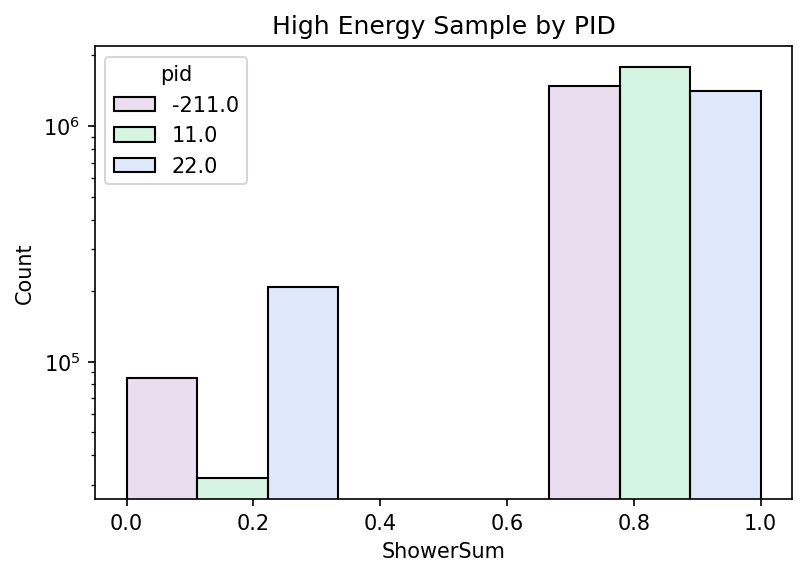

In [25]:
plt.figure(dpi=150)
plt.title("High Energy Sample by PID")
#plt.xlabel("PID")

sns.histplot(sim_df, x=(sim_df["ShowerSum"]>20).astype(int), hue="pid", #weights="# rate", 
             multiple="dodge", palette=sns.color_palette(best_colors[:-1]), alpha=0.2, bins=3)

plt.yscale("log")

In [37]:
sim_df.columns[[0, -3,-1]]

Index(['# rate', 'Npesum', 'NCh'], dtype='object')

In [27]:
sim_df.columns[[0, 15,16,17,18, 19,20,21,22]]#, 24,27,30,33, 39, 41,47,53,59, -3,-1]]

#[[15,16,17,18, 19,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5]]

Index(['# rate', 'PreShSum', 'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum',
       'Shower_l', 'Shower_r', 'Shower_t'],
      dtype='object')

## Samples

In [20]:
sim_df.columns[[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]]

Index(['# rate', 'PreShSum', 'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum',
       'Shower_l', 'Shower_r', 'Shower_t', 'SC_A_Eendsum', 'SC_D_Eendsum',
       'SC_C_Eendsum', 'SC_B_Eendsum', 'LASPD_Eendsum', 'GEM00_n', 'GEM10_n',
       'GEM01_n', 'GEM11_n', 'Npesum', 'NCh'],
      dtype='object')

In [100]:
%%time
#Number of background events per data event
n_bkg = 0
keeps = (sim_df["pid"]==11) | ((sim_df["pid"]==-211) & (sim_df["p"]<5))

data_np = (sim_df[keeps]).to_numpy()#(sim_df["pid"]!=111) sim_df[(sim_df["ShowerSum"]>1) & (sim_df["pid"]!=111) ].to_numpy()
bkg_np = ((raw_bkg_df.sample(n=n_bkg*len(sim_df[keeps]), random_state=42, replace=1)).to_numpy()).reshape((len(sim_df[keeps]),-1,
                                                                                                           len(raw_bkg_df.columns))).sum(axis=1)
cher_np = (Cher_df[keeps]).to_numpy()

#X = data_np[:,[0, 4,5,6,7, 15,16,17,18, 19,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5]] #with momentum #np.delete(data_np, np.arange(0,9,1), 1)
               #15, 19, 24,27,30,33, 39, 41,47,53,59, -2]]
    
#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]] #Baseline
#X = data_np[:,[0, 15,16,17,18, 19,20,21,22]] #ECal
X = data_np[:,[0, -3,-1]] #Cher


X_bkg = bkg_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -2,-1]]

#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5, -4,-3, -2,-1]] #With clustering
X_Cher = cher_np[:,np.arange(0,16,1)]

#Full_X = np.column_stack([X,X_Cher])

Full_X = (X)# + X_bkg)*np.random.normal(1,.1,(X).shape)#*(np.random.random((X).shape)>0.1)

#Get Labels
y = data_np[:,8].astype(int)
y[y==11] = 0
#y += np.round(np.random.uniform(0,1,len(y))).astype(int)
#y[y==22] = 1
y[y==-211] = 1

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(Full_X)

#data = scaled_data
data = scaled_data#np.column_stack([scaled_data,X_Cher/np.max(X_Cher)])

# print(data.min(), data.max())

#train_data, test_data, train_labels, test_labels = train_test_split(data[:, :-1], data[:, -1], test_size=0.25, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(data, y, test_size=0.4, random_state=42)

print("Train:", len(train_data))
print("Test:", len(test_data))

Train: 1474314
Test: 982877
CPU times: user 2.96 s, sys: 4.78 s, total: 7.74 s
Wall time: 7.65 s


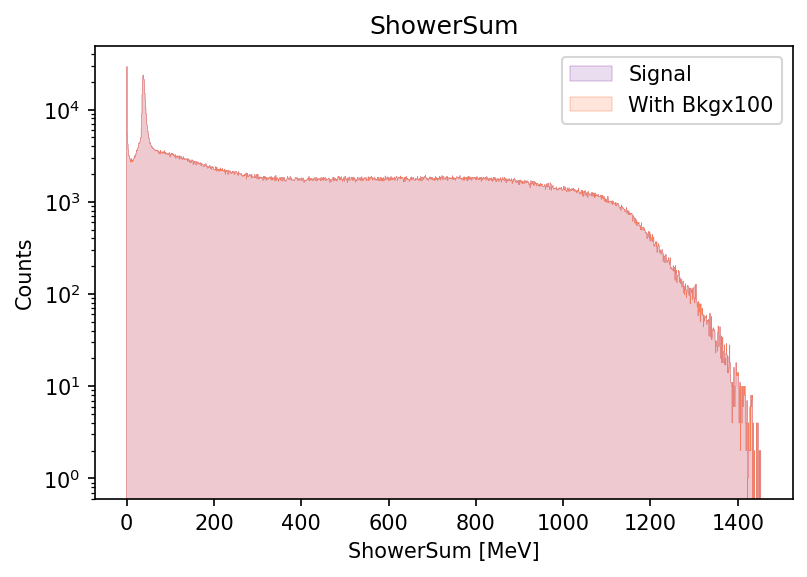

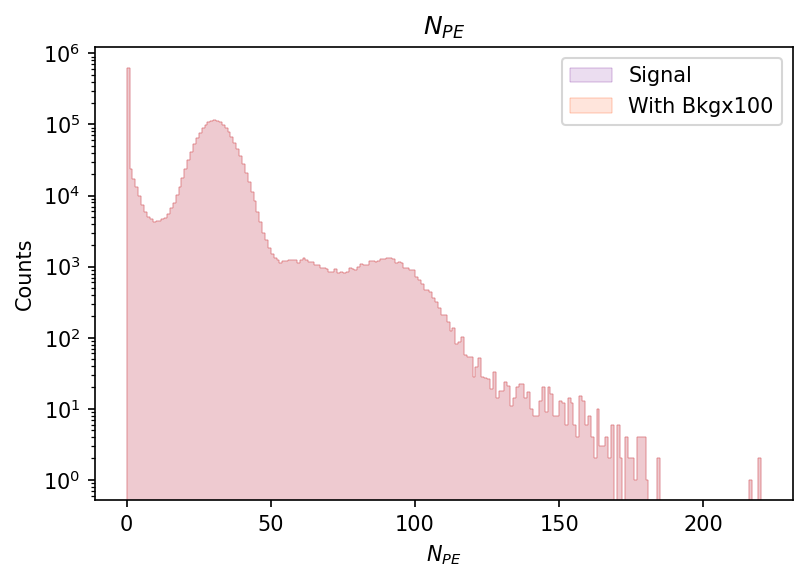

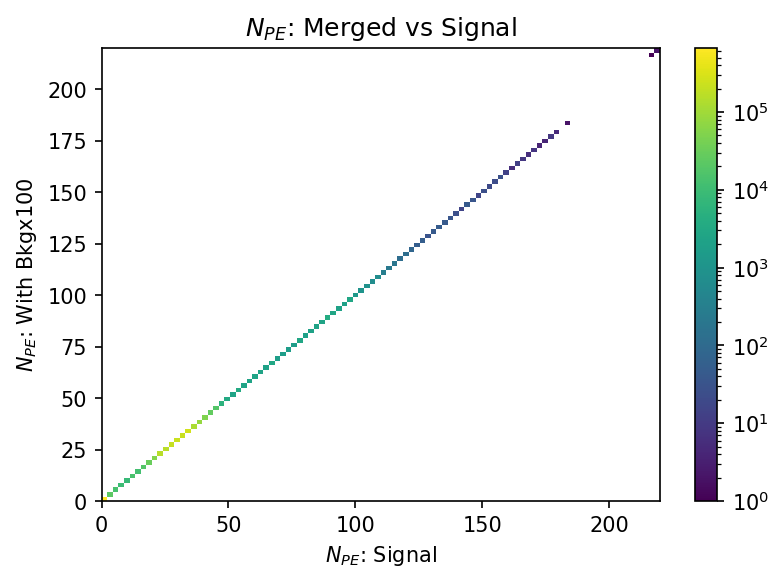

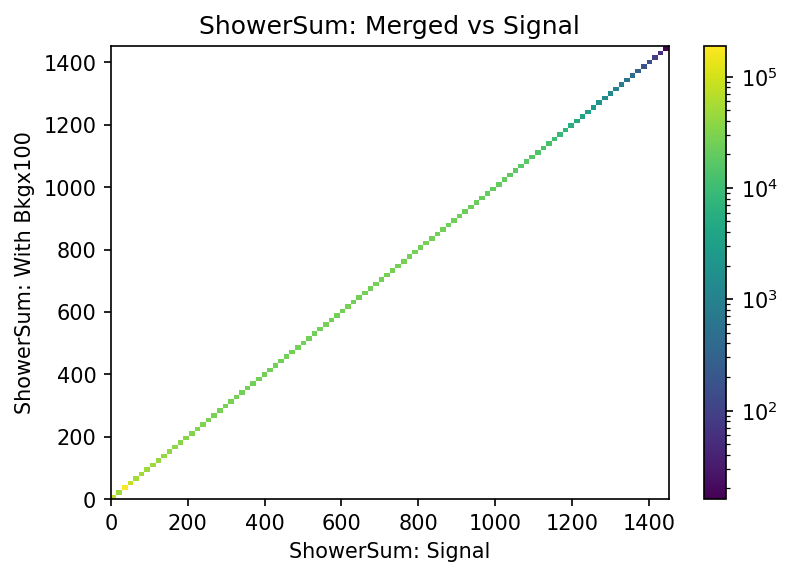

In [52]:
other_stuff = "_All"#"_Smear_Missing"

plt.figure(dpi=150)
plt.title("ShowerSum")
plt.xlabel("ShowerSum [MeV]")
plt.ylabel("Counts")
sns.histplot(X[:,5], alpha=0.2, element="step", binwidth=1, lw=0.2, label="Signal")
sns.histplot(Full_X[:,5], alpha=0.2, element="step", binwidth=1, color="coral", lw=0.2, label="With Bkgx100")
plt.yscale("log")
plt.legend()
plt.savefig(f"Plots/MergedBkg_ShowerSum_Bkg100{other_stuff}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("$N_{PE}$")
plt.xlabel("$N_{PE}$")
plt.ylabel("Counts")
sns.histplot(X[:,-2], alpha=0.2, element="step", binwidth=1, lw=0.2, label="Signal")
sns.histplot(Full_X[:,-2], alpha=0.2, element="step", binwidth=1, color="coral", lw=0.2, label="With Bkgx100")
plt.yscale("log")
plt.legend()
plt.savefig(f"Plots/MergedBkg_NPE_Bkg100{other_stuff}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("$N_{PE}$: Merged vs Signal")
plt.xlabel("$N_{PE}$: Signal")
plt.ylabel("$N_{PE}$: With Bkgx100")
plt.hist2d(X[:,-2], Full_X[:,-2], bins=100, norm=LogNorm())
plt.colorbar()
plt.savefig(f"Plots/MergedBkg_NPE_2D_Bkg100{other_stuff}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("ShowerSum: Merged vs Signal")
plt.xlabel("ShowerSum: Signal")
plt.ylabel("ShowerSum: With Bkgx100")
plt.hist2d(X[:,5], Full_X[:,5], bins=100, norm=LogNorm())
plt.colorbar()
plt.savefig(f"Plots/MergedBkg_ShowerSum_2D_Bkg100{other_stuff}.pdf")



In [53]:
np.unique(y,)

array([0, 1])

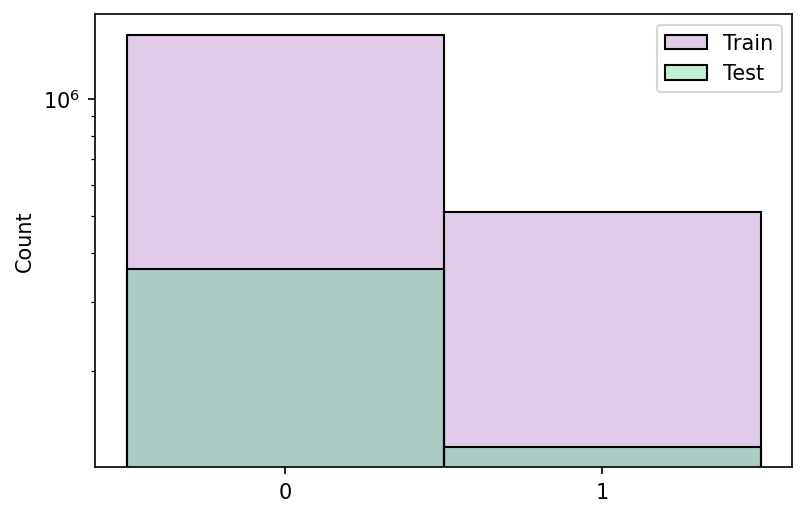

In [97]:
plt.figure(dpi=150)
sns.histplot(train_labels.astype(str),label="Train",alpha=0.3)
sns.histplot(test_labels.astype(str),label="Test",alpha=0.3,color=best_colors[1])

plt.legend()
plt.yscale("log")

## Meterics

In [63]:
#Electron efficiency
def electron_eff(y_true, y_pred):
    num_e = K.sum(y_true==0)
    pred_e = K.sum(y_pred==0)
    
    return pred_e/num_e

#Pion Rejection
def pi_reject(y_true, y_pred):
    num_pi = K.sum(y_true!=0)
    pi_pred_e = tf.keras.layers.Multiply()([y_pred, y_true])#K.sum((y_pred==0)*(y_true!=0))
    
    return 1-(pi_pred_e/num_pi)

model = 
solid.models.models.get_custom_model_v0(inp_shape=54)
model = get_custom_model_v0(inp_shape=(data).shape[-1])
model.summary()

#opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt = tf.keras.optimizers.SGD(lr=0.01)
model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer=opt)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.85, patience=5, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=30, verbose=1,
                               baseline=None, restore_best_weights=True)


## Model

In [64]:
model_ECal = tf.keras.Sequential([
    Input(data[:,1:].shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])

model_ECal.summary()

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_ECal.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
                  metrics=['accuracy'])#, electron_eff, pi_reject])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               4608      
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [29]:
model_Cher = tf.keras.Sequential([
    Input(data[:,1:].shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])

model_Cher.summary()


opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_Cher.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
                  metrics=['accuracy'])#, electron_eff, pi_reject])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               1536      
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [53]:
model_baseline = tf.keras.Sequential([
    Input(data[:,1:].shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])

model_baseline.summary()


opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_baseline.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
                  metrics=['accuracy'])#, electron_eff, pi_reject])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               10240     
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)              

In [57]:
np.unique(train_labels)

array([0, 1])

## Training

In [65]:
%%time
train_model = model_ECal #model_baseline # #model_Cher

version = "SULI_Week5_Pencil_ECal"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.01, factor=0.9, patience=3, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6) #use 1e-4, 10
un_cts = np.unique(y, return_counts=1)

history = train_model.fit(train_data[:,1:], train_labels, batch_size=3000, epochs=100,
                    #class_weight = {int(un_cts[0][0]):1/un_cts[1][0], int(un_cts[0][1]):1/un_cts[1][1], int(un_cts[0][2]):1/un_cts[1][2]},
                    #{0:1.5, 1:30, 2:8}, #{0:10, 1:1, 2:10, 3:1}, #{0:1.5, 1:30, 2:8
                    #sample_weight = np.abs((train_labels-1.3)**-1),#train_labels,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(test_data[:,1:], test_labels))


Epoch 1/100
492/492 [==============================] - 20s 39ms/step - loss: 0.1909 - accuracy: 0.9386 - val_loss: 1.0656 - val_accuracy: 0.7422
Epoch 2/100
492/492 [==============================] - 19s 39ms/step - loss: 0.1217 - accuracy: 0.9540 - val_loss: 0.1021 - val_accuracy: 0.9600
Epoch 3/100
492/492 [==============================] - 19s 39ms/step - loss: 0.1128 - accuracy: 0.9569 - val_loss: 0.0990 - val_accuracy: 0.9610
Epoch 4/100
492/492 [==============================] - 19s 39ms/step - loss: 0.1094 - accuracy: 0.9586 - val_loss: 0.1057 - val_accuracy: 0.9563
Epoch 5/100
492/492 [==============================] - 19s 39ms/step - loss: 0.1068 - accuracy: 0.9599 - val_loss: 0.0974 - val_accuracy: 0.9628
Epoch 6/100
492/492 [==============================] - 19s 39ms/step - loss: 0.1048 - accuracy: 0.9608 - val_loss: 0.0951 - val_accuracy: 0.9637
Epoch 7/100
492/492 [==============================] - 19s 39ms/step - loss: 0.1036 - accuracy: 0.9612 - val_loss: 0.0956 - val_ac

In [66]:
%%time

##Save Model
tf.keras.models.save_model(train_model,f"Models/{version}/Model")
train_model.save_weights(f"Models/{version}/Weights")
 
# load model
tf.keras.models.load_model(f"Models/{version}/Model").summary()
savedModel = train_model.load_weights(f"Models/{version}/Weights")

INFO:tensorflow:Assets written to: Models/SULI_Week5_Pencil_ECal/Model/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               4608      
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
__________________________________________

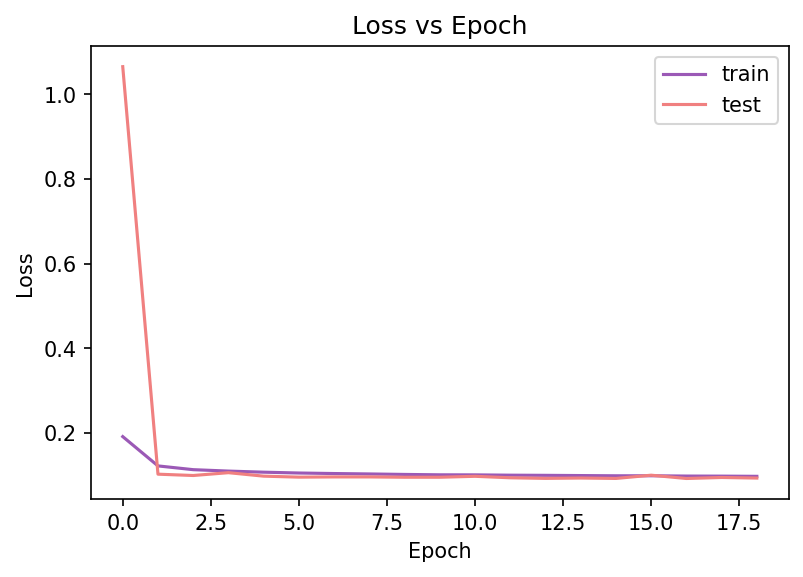

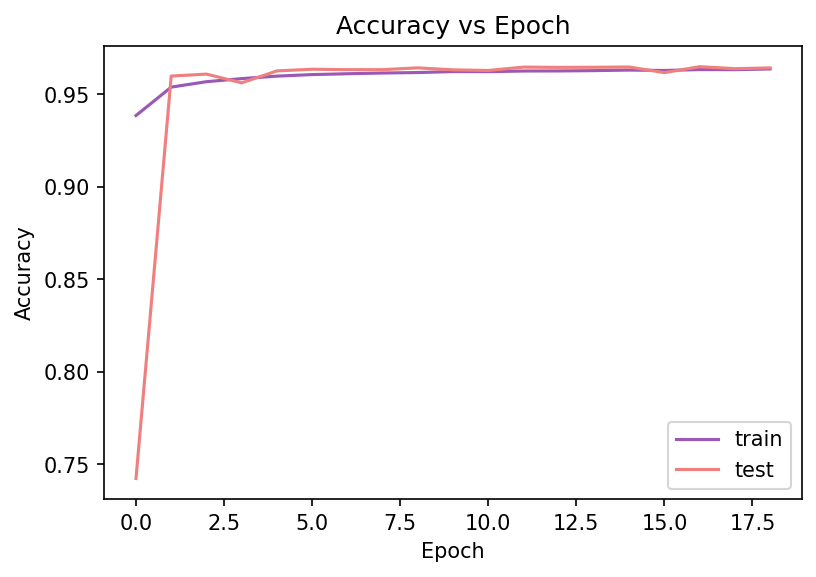

In [67]:
plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Accuracy_{version}.pdf")
plt.show()

## Confusion Matrix

CPU times: user 1min 17s, sys: 10.6 s, total: 1min 27s
Wall time: 33.8 s


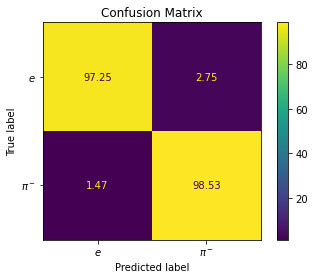

In [33]:
%%time

predictions = train_model.predict(test_data[:,1:])
results = np.argmax(predictions, axis=1)

#e_eff = ((results==0)*(test_labels==0)).sum()/(test_labels==0).sum()
#pi_rej = 1-(((results==0)*(test_labels==2)).sum()/(test_labels==2).sum())

#print("e Efficiency:",e_eff)
#print("Pi Rejection:",pi_rej)

cm= confusion_matrix(test_labels,results)#, sample_weight=test_data[:,0])
cm_percent = (cm)/(np.repeat(cm.sum(axis=1),2,axis=0).reshape(2,2))*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,display_labels=["$e$","$\pi^-$"])#[11,22,211]) #"$\gamma$",
disp.plot(values_format='.2f')

plt.title(f"Confusion Matrix")#: $e$:{e_eff*100: .1f}% & $\pi$:{pi_rej*100: .1f}%")

plt.savefig(f"Plots/Sim_Confusion_{version}.pdf")



plt.figure(dpi=150)
plt.title("Shower Sum vs Preshower Sum: $\pi$")
plt.xlabel("Preshower Sum [MeV]")
plt.ylabel("Shower Sum [MeV]")

plt.hist2d(test_data[:,1][(results==2)], test_data[:,5][(results==2)], norm=LogNorm(),bins=100)

plt.colorbar()

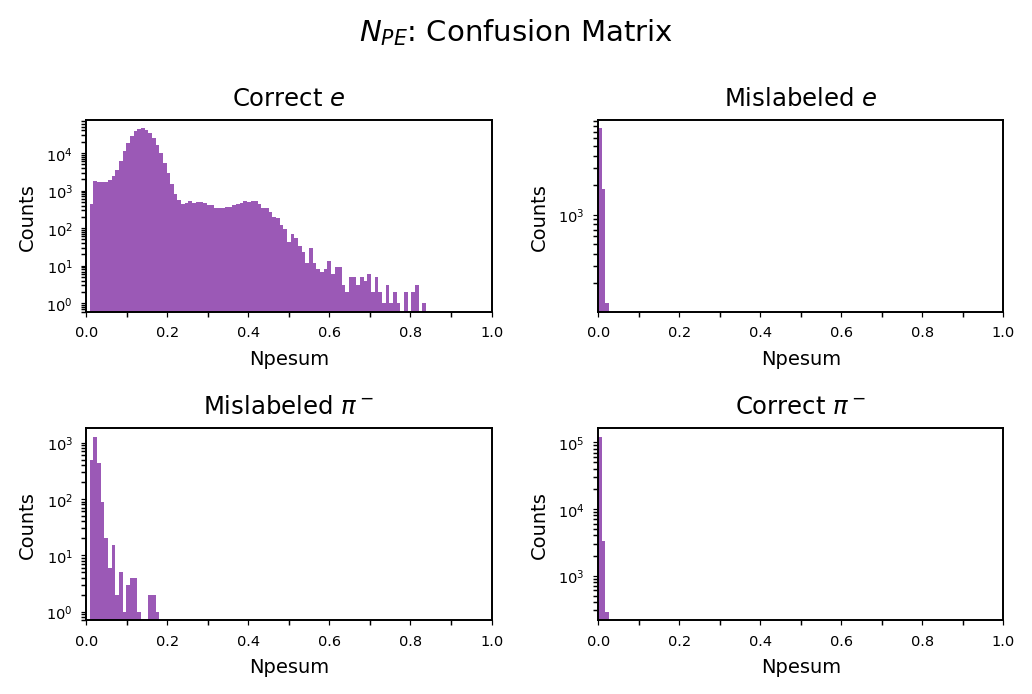

In [104]:
"""labels = ["Correct $e$", "Mislabeled $e$", "Mislabeled $\pi^-$", "Correct $\pi^-$"]    
    
fig, axes = plt.subplots(2, 2, dpi=175)    
plt.suptitle("PreShSum vs ShowerSum: Confusion Matrix")

#Loop through frames
for j in range(4):

    #plt.subplot(2,2,i+1)
    axes[int(j/2),j%2].set_title(labels[j], fontsize=10)
    axes[int(j/2),j%2].set_xlabel("PreShSum", fontsize=8)
    axes[int(j/2),j%2].set_ylabel("ShSum", fontsize=8)
    
    #Match logic
    keeps = (test_labels==int(j/2)) & (results==j%2)
    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(test_data[:,5][keeps], test_data[:,1][keeps], norm=LogNorm(), bins=100)

    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.01,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.01,.1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.01,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.01,.1), minor=1)
    
    axes[int(j/2),j%2].set_xlim(0,1)
    axes[int(j/2),j%2].set_ylim(0,.51)
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)

plt.tight_layout()
plt.savefig("Plots/ShSum_PreShSum_Confusion_{version}.pdf")
"""


labels = ["Correct $e$", "Mislabeled $e$", "Mislabeled $\pi^-$", "Correct $\pi^-$"]    
    
fig, axes = plt.subplots(2, 2, dpi=175)    
plt.suptitle("$N_{PE}$: Confusion Matrix")

for j in range(4):

    #plt.subplot(2,2,i+1)
    axes[int(j/2),j%2].set_title(labels[j], fontsize=10)
    axes[int(j/2),j%2].set_xlabel("Npesum", fontsize=8)
    axes[int(j/2),j%2].set_ylabel("Counts", fontsize=8)

    keeps = (test_labels==int(j/2)) & (results==j%2)
    axes[int(j/2),j%2].hist(test_data[:,-2][keeps], bins=np.linspace(0,1,112))

    #cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    #cbar.ax.tick_params(labelsize=4)
    
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.01,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.01,.1), minor=1)
    
    axes[int(j/2),j%2].set_xlim(0,1)
    #axes[int(j/2),j%2].set_ylim(0,.5)
    
    axes[int(j/2),j%2].set_yscale("log")
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)

plt.tight_layout()
plt.savefig("Plots/NPE_Confusion_{version}.pdf")

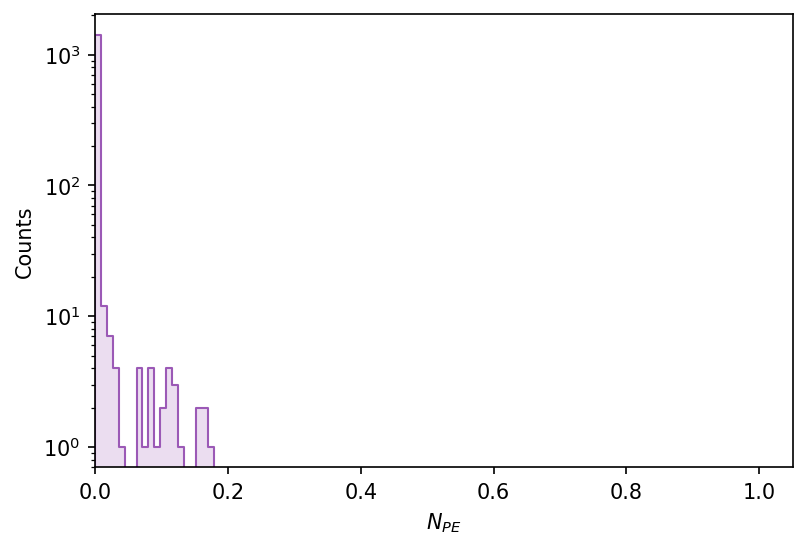

In [76]:
plt.figure(dpi=150)
#plt.title("$N_{Ch}$: Misclassified")
plt.xlabel("$N_{PE}$")
plt.ylabel("Counts")

sns.histplot(x=test_data[((results==0) & (1==test_labels))][:,-2], #weights=test_data[:,0],
             #palette=sns.color_palette(best_colors[:-1]), 
             element="step", alpha=0.2, binwidth=1/112)

plt.xlim(0,1.05)
plt.yscale("log")

#plt.savefig("Plots/NCh_Misclassified.pdf")
plt.show()


## Compare Models

In [9]:
def get_eff_rej(predictions, test_labels, e_pid=0, intervals=1000, low_lim=0.4):
    spacing = .0001
    #prob_limits = np.arange(.40,1, spacing)
    prob_limits = np.linspace(low_lim,1, int(intervals))
    #prob_limits = np.logspace(-.5,0, int(3e4))
    
    #Get Events
    e_events = (test_labels==e_pid)
    pi_events = (test_labels!=e_pid)
    
    #Get Nums
    num_e = (test_labels==e_pid).sum()
    num_pi = (test_labels!=e_pid).sum()

    true_e, false_e = [], []
    for p_val in prob_limits:
        pids = predictions[:,0]>p_val

        true_e.append(((pids==e_pid)*e_events).sum()/num_e)
        false_e.append(((pids==e_pid)*pi_events).sum()/num_pi)
    
    return np.array(true_e), np.array(false_e)

#GeV6_true_e, GeV6_false_e = get_eff_rej(GeV6_predictions, test_labels)

In [148]:
%%time

#ECal_true_e, ECal_false_e = get_eff_rej(ECal_predictions, test_labels, intervals=1e5)
#Cher_true_e, Cher_false_e = get_eff_rej(Cher_predictions, test_labels, intervals=1e5)
#Both_predictions = ECal_predictions*Cher_predictions
#Both_true_e, Both_false_e = get_eff_rej(Both_predictions/np.max(Both_predictions), test_labels, intervals=1e4, low_lim=0.1)

#baseline_true_e_part2, baseline_false_e_part2 = get_eff_rej(baseline_predictions, test_labels, intervals=5e4, low_lim=.999)


CPU times: user 19 s, sys: 29.8 ms, total: 19 s
Wall time: 19.1 s


In [68]:
%%time
#full_predictions = full_model.predict(test_data)
#MLP_true_e, MLP_false_e = get_eff_rej(MLP_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_MLP_full.out', np.column_stack([MLP_true_e, MLP_false_e]), delimiter=',')

#full_predictions = full_model.predict(test_data)
#CNN_true_e, CNN_false_e = get_eff_rej(CNN_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_CNN_full.out', np.column_stack([CNN_true_e, CNN_false_e]), delimiter=',')

#baseline_predictions = model_baseline.predict(test_data[:,1:])
#baseline_true_e, baseline_false_e = get_eff_rej(baseline_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/ECal_Cher/ML_prob_baseline.out', np.column_stack([baseline_true_e, baseline_false_e]), delimiter=',')


#Cher_predictions = model_Cher.predict(test_data[:,1:])
#Cher_true_e, Cher_false_e = get_eff_rej(Cher_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/ECal_Cher/ML_prob_Cher.out', np.column_stack([Cher_true_e, Cher_false_e]), delimiter=',')

ECal_predictions = model_ECal.predict(test_data[:,1:])
ECal_true_e, ECal_false_e = get_eff_rej(ECal_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/ECal_Cher/ML_prob_ECal.out', np.column_stack([ECal_true_e, ECal_false_e]), delimiter=',')

Both_predictions = ECal_predictions*Cher_predictions
Both_true_e, Both_false_e = get_eff_rej((Both_predictions/(Both_predictions.sum(axis=1))[:,None]), 
                                        test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/ECal_Cher/ML_prob_Both.out', np.column_stack([Both_true_e, Both_false_e]), delimiter=',')
#Both_true_e_v0, Both_false_e_v0 = np.hsplit(np.loadtxt("ML_Probs/ECal_Cher/ML_prob_Both.out", delimiter=","),2)


##For Momentum Slices
#GeV05_predictions = mom_05GeV.predict(test_data[:,1:])
#GeV05_true_e, GeV05_false_e = get_eff_rej(GeV05_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV05.out', np.column_stack([GeV05_true_e, GeV05_false_e]), delimiter=',')
#GeV05_true_e, GeV05_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV05.out", delimiter=","),2)

#GeV10_predictions = mom_10GeV.predict(test_data[:,1:])
#GeV10_true_e, GeV10_false_e = get_eff_rej(GeV10_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV10.out', np.column_stack([GeV10_true_e, GeV10_false_e]), delimiter=',')
#GeV10_true_e, GeV10_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV10.out", delimiter=","),2)

#GeV15_predictions = mom_15GeV.predict(test_data[:,1:])
#GeV15_true_e, GeV15_false_e = get_eff_rej(GeV15_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV15.out', np.column_stack([GeV15_true_e, GeV15_false_e]), delimiter=',')
#GeV15_true_e, GeV15_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV15.out", delimiter=","),2)

#GeV20_predictions = mom_20.predict(test_data[:,1:])
#GeV20_true_e, GeV20_false_e = get_eff_rej(GeV20_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV20.out', np.column_stack([GeV20_true_e, GeV20_false_e]), delimiter=',')
#GeV20_true_e, GeV20_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV20.out", delimiter=","),2)

#GeV25_predictions = mom_25GeV.predict(test_data[:,1:])
#GeV25_true_e, GeV25_false_e = get_eff_rej(GeV25_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV25.out', np.column_stack([GeV25_true_e, GeV25_false_e]), delimiter=',')
#GeV25_true_e, GeV25_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV25.out", delimiter=","),2)

#GeV30_predictions = mom_30GeV.predict(test_data[:,1:])
#GeV30_true_e, GeV30_false_e = get_eff_rej(GeV30_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV30.out', np.column_stack([GeV30_true_e, GeV30_false_e]), delimiter=',')
#GeV30_true_e, GeV30_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV30.out", delimiter=","),2)

#GeV35_predictions = mom_35GeV.predict(test_data[:,1:])
#GeV35_true_e, GeV35_false_e = get_eff_rej(GeV35_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV35.out', np.column_stack([GeV35_true_e, GeV35_false_e]), delimiter=',')
#GeV35_true_e, GeV35_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV35.out", delimiter=","),2)

#GeV40_predictions = mom_40GeV.predict(test_data[:,1:])
#GeV40_true_e, GeV40_false_e = get_eff_rej(GeV40_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV40.out', np.column_stack([GeV40_true_e, GeV40_false_e]), delimiter=',')
#GeV40_true_e, GeV40_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV40.out", delimiter=","),2)

#GeV45_predictions = GeV45_model.predict(test_data[:,1:])
#GeV45_true_e, GeV45_false_e = get_eff_rej(GeV45_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV45.out', np.column_stack([GeV45_true_e, GeV45_false_e]), delimiter=',')
#GeV45_true_e, GeV45_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV45.out", delimiter=","),2)

#GeV50_predictions = GeV50_model.predict(test_data[:,1:])
#GeV50_true_e, GeV50_false_e = get_eff_rej(GeV50_predictions, test_labels)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV50.out', np.column_stack([GeV50_true_e, GeV50_false_e]), delimiter=',')
#GeV50_true_e, GeV50_false_e = np.hsplit(np.loadtxt("ML_Probs/Cher_MomSlice/ML_Cher_prob_GeV50.out", delimiter=","),2)


CPU times: user 5min 11s, sys: 11.1 s, total: 5min 22s
Wall time: 4min 24s


### Comparison Plots

/tmp/ipykernel_263043/2526766867.py:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-ECal_false_e),1-ECal_true_e, label="ECal")#, c="cornflowerblue")
/tmp/ipykernel_263043/2526766867.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Cher_false_e),1-Cher_true_e, label="Cher")#, c="#2ecc71")
/tmp/ipykernel_263043/2526766867.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Combined")#, c="#9b59b6")
/tmp/ipykernel_263043/2526766867.py:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-baseline_false_e),1-baseline_true_e, label="Baseline", c="darkorange")


[]

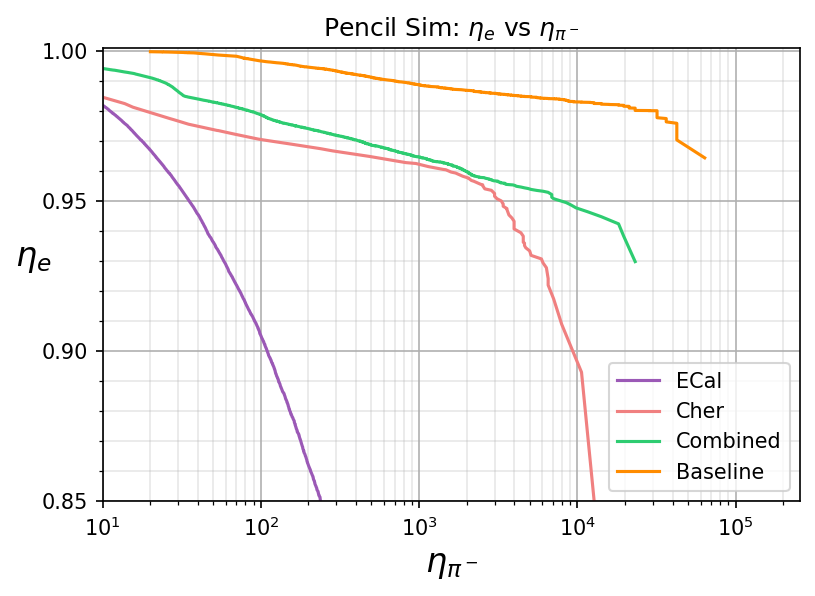

In [60]:
fig, ax = plt.subplots(dpi=150)
plt.title("Pencil Sim: $\eta_e$ vs $\eta_{\pi^-}$")#$\pi^-$ Rejection")
plt.ylabel("$\eta_e$",rotation=0, fontsize=16)
#plt.xlabel("$\pi^-$ Rejection")
plt.xlabel("$\eta_{\pi^-}$", fontsize=16)

#plt.plot(1/(1-baseline_false_e),1-baseline_true_e, label="baseline", c="#9b59b6")
plt.plot(1/(1-ECal_false_e),1-ECal_true_e, label="ECal")#, c="cornflowerblue")

plt.plot(1/(1-Cher_false_e),1-Cher_true_e, label="Cher")#, c="#2ecc71")
plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Combined")#, c="#9b59b6")
plt.plot(1/(1-baseline_false_e),1-baseline_true_e, label="Baseline", c="darkorange")

#plt.scatter(50,.9, marker="*",s=150,c="magenta",zorder=100,label="ECal PCDR")

#plt.plot([0,1],[1,0])

#get handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
#order = [2,4,0,1,3,5,6]

#add legend to plot
plt.legend()#[handles[idx] for idx in order],[labels[idx] for idx in order])

#ax.set_xticks(np.arange(0,501,25), minor=1)
ax.set_yticks(np.arange(0.85,1.1,.05))
ax.set_yticks(np.arange(0.85,1.1,.01), minor=1)

plt.xlim(10,(test_labels==1).sum())#1e6)
plt.ylim(0.85,1.001)

plt.xscale("log")
#plt.yscale("log")

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)

plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Full_log.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_ECal.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_ECal_log.pdf")

plt.plot()

### Ensemble Plots

/tmp/ipykernel_116249/338150843.py:25: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-ECal_false_e),1-ECal_true_e, label="ECal")
/tmp/ipykernel_116249/338150843.py:27: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Cher_false_e),1-Cher_true_e, label="Cher")
/tmp/ipykernel_116249/338150843.py:28: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Ensemble")


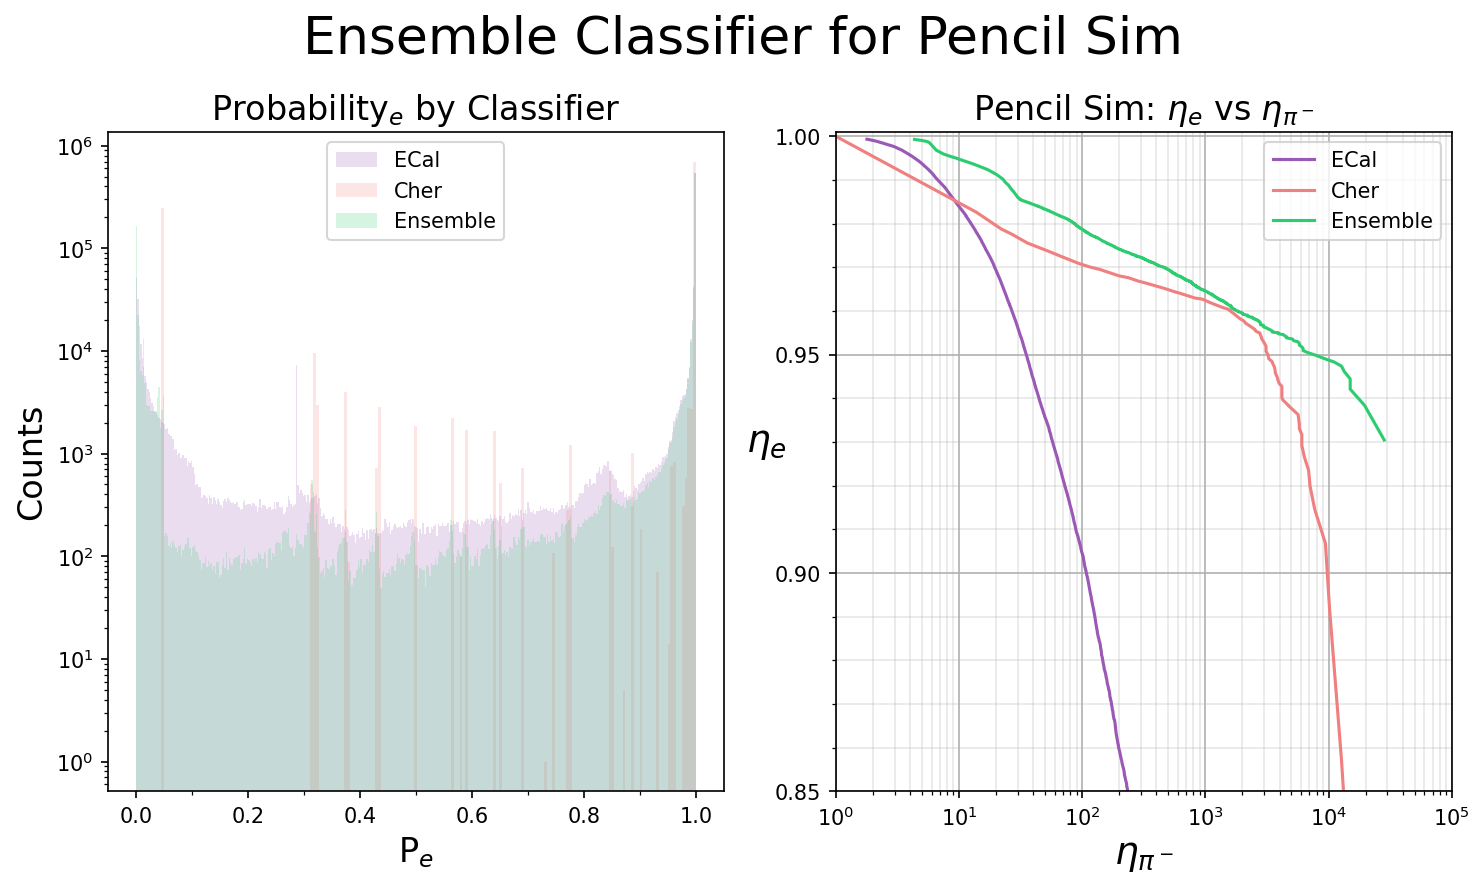

In [83]:
plt.figure(dpi=150, figsize=(10,6))
plt.suptitle("Ensemble Classifier for Pencil Sim", fontsize=25)

ax1 = plt.subplot(1,2,1)
plt.title("Probability$_e$ by Classifier", fontsize=16)
plt.xlabel("P$_e$", fontsize=16)
plt.ylabel("Counts", fontsize=16)

plt.hist(ECal_predictions[:,0], bins=np.linspace(0,1,400), alpha=0.2, label="ECal")
n, bins, _ = plt.hist(Cher_predictions[:,0], bins=np.linspace(0,1,200), alpha=0.2, label="Cher")
plt.hist(Both_predictions[:,0], bins=np.linspace(0,1,400), alpha=0.2, label="Ensemble")

ax1.set_xticks(np.arange(0,1.1,.2))
ax1.set_xticks(np.arange(0,1.1,.1), minor=1)
plt.yscale("log")

plt.legend()


ax2 = plt.subplot(1,2,2)
plt.title("Pencil Sim: $\eta_e$ vs $\eta_{\pi^-}$", fontsize=16)
plt.ylabel("$\eta_e$",rotation=0, fontsize=18)
plt.xlabel("$\eta_{\pi^-}$", fontsize=18)

plt.plot(1/(1-ECal_false_e),1-ECal_true_e, label="ECal")

plt.plot(1/(1-Cher_false_e),1-Cher_true_e, label="Cher")
plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Ensemble")
#plt.plot(1/(1-Both_false_e_v0),1-Both_true_e_v0, label="Combined")

plt.legend()

plt.xscale("log")
#ax.set_xticks(np.arange(0,501,25), minor=1)

ax2.set_yticks(np.arange(0.85,1.1,.05))
ax2.set_yticks(np.arange(0.85,1.1,.01), minor=1)

plt.xlim(1,10**5)#(test_labels==1).sum())#1e6)
plt.ylim(0.85,1.001)

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)

plt.tight_layout()
plt.savefig("Plots/EnsembleClassifier.pdf")


In [102]:
len(np.unique(X[:,1:],axis=0))

1306

In [111]:
len(np.unique(test_data[:,1:]*np.tile([220,16],(len(test_data),1))))

180

In [117]:
len(np.unique((test_data[:,1:]*np.tile([220,16],(len(test_data),1))).astype(int),axis=0))

997

In [124]:
len(np.unique(np.round(Cher_predictions[:,0]*1e12)))

447

## CL, Prob, & ML
***
The

In [6]:
def get_eff_rej_new(predictions, test_labels, e_pid=0, intervals=1000, low_lim=0.4):
    spacing = .0001
    #prob_limits = np.arange(.40,1, spacing)
    prob_limits = np.unique(np.round(predictions[:,0],4)) #np.linspace(low_lim,1, int(intervals))
    #prob_limits = np.logspace(-.5,0, int(3e4))
    
    #Get Events
    e_events = (test_labels==e_pid)
    pi_events = (test_labels!=e_pid)
    
    #Get Nums
    num_e = (test_labels==e_pid).sum()
    num_pi = (test_labels!=e_pid).sum()

    true_e, false_e = [], []
    for p_val in prob_limits:
        pids = predictions[:,0]>p_val

        true_e.append(((pids==e_pid)*e_events).sum()/num_e)
        false_e.append(((pids==e_pid)*pi_events).sum()/num_pi)
    
    return np.array(true_e), np.array(false_e)

#GeV6_true_e, GeV6_false_e = get_eff_rej(GeV6_predictions, test_labels)

In [7]:
%%time 
cl_true_e, cl_pi_rej = [], []

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))

true_electrons = sim_df[(sim_df["pid"]==11) & (TS3_req)]
true_pim = sim_df[((sim_df["pid"]==-211) & (sim_df["p"]<5)) & (TS3_req)]

num_e, num_pim = len(true_electrons), len(true_pim)

for cut_val in np.arange(0,81, 1):
    cl_true_e.append((((true_electrons["Npesum"]>cut_val)).sum())/num_e)
    cl_pi_rej.append((((true_pim["Npesum"]<cut_val)).sum())/num_pim)
    
    if cut_val%10==0: print(cut_val)
    
cl_true_e, cl_pi_rej = np.array(cl_true_e), np.array(cl_pi_rej)

0
10
20
30
40
50
60
70
80
CPU times: user 1.38 s, sys: 184 ms, total: 1.57 s
Wall time: 788 ms


### N_PE

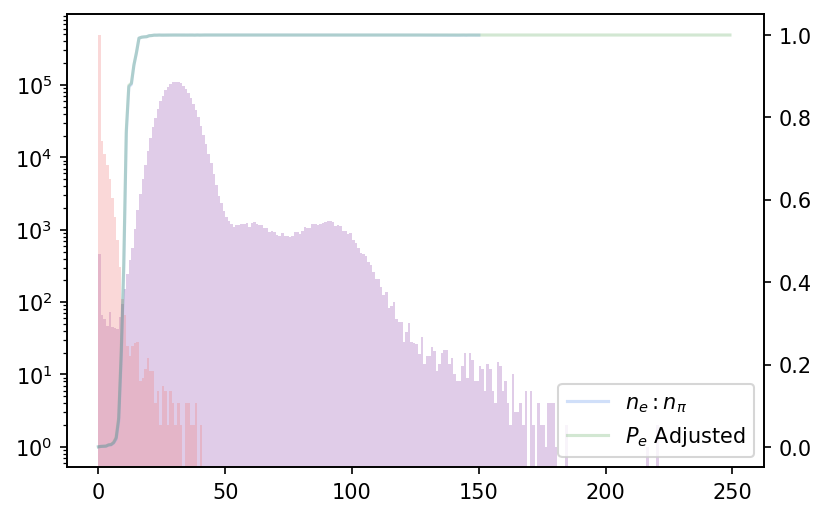

In [8]:

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))
Prob_1D_labels = sim_df["pid"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_1D_NPE_vals = sim_df["Npesum"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_1D_labels[Prob_1D_labels==11] = 0
Prob_1D_labels[Prob_1D_labels==-211] = 1


fig, ax1 = plt.subplots(dpi=150)
ax2 = ax1.twinx()

n_e,bins_e, _ = ax1.hist(sim_df["Npesum"][(sim_df["pid"]==11)&(TS3_req)], alpha=0.3, bins=np.arange(0,251,1))
n_pi,bins_pi, _ = ax1.hist(sim_df["Npesum"][(sim_df["pid"]==-211)&(TS3_req)&(sim_df["p"]<5)], alpha=0.3, bins=np.arange(0,251,1))

ax1.set_yscale("log")
#plt.show()

#plt.figure(dpi=150)
#plt.title("Baseline $P_e$ for $N_{PE}$")
#plt.xlabel("$N_{PE}$")
#plt.ylabel("$P_e$", rotation=0, fontsize=16)
ax2.plot(bins_e[:-100], ((n_e/n_e.sum())/(((n_pi+.001)/(n_pi+.001).sum()) + ((n_e+.001)/(n_e+.001).sum())))[:-99], 
         label="$n_e:n_{\pi}$", alpha=0.3, color="cornflowerblue")


###########################
raw_density = np.column_stack([(((n_e+.001)+bins_e[:-1])/(n_e+.001).sum()), ((n_pi+.001)/(n_pi+.001).sum())])
prob_vals = (raw_density/(raw_density.sum(axis=1)[:,None]))
Prob_1D_probs = prob_vals

#plt.hist(prob_vals[:,0], bins=np.arange(0,1.0001,.025), histtype="stepfilled", alpha=0.3)
ax2.plot(prob_vals[:,0], label="$P_e$ Adjusted", alpha=0.2, color="forestgreen")
plt.legend()


### ECal

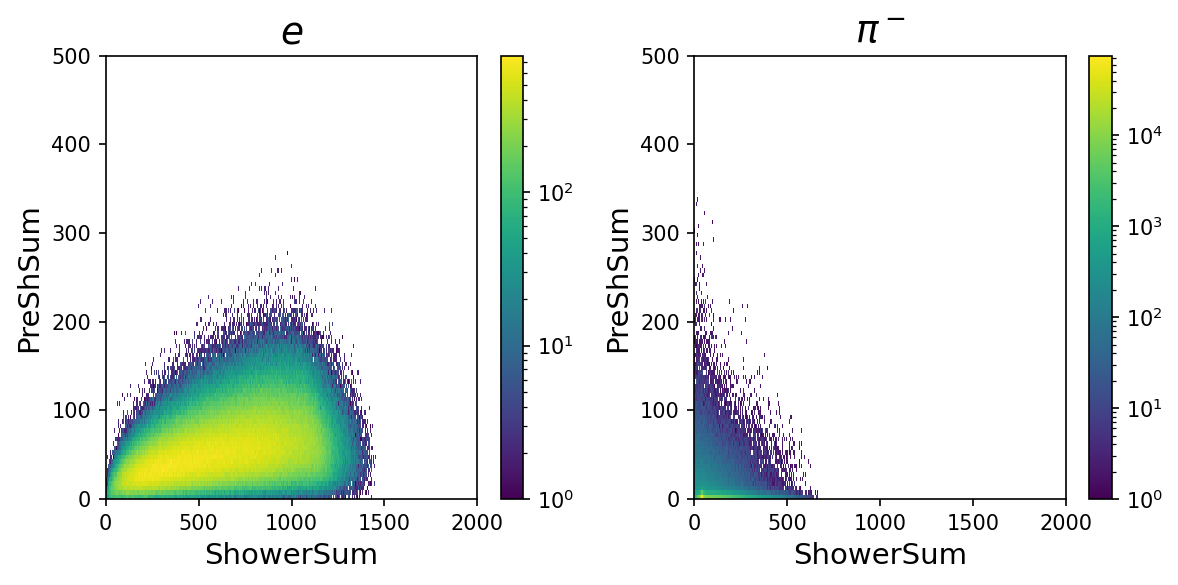

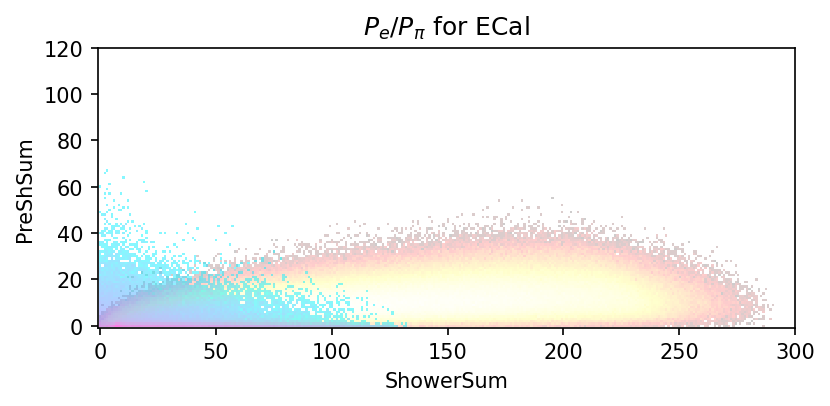

In [9]:
Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))
Prob_2D_labels = sim_df["pid"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_2D_PShSum = sim_df["PreShSum"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_2D_ShSum = sim_df["ShowerSum"][((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) & (TS3_req)]
Prob_2D_labels[Prob_2D_labels==11] = 0
Prob_2D_labels[Prob_2D_labels==-211] = 1

fig,axes = plt.subplots(1,2, dpi=150, figsize=(8,4))

axes[0].set_title(f"$e$", fontsize=18)
axes[0].set_xlabel("ShowerSum", fontsize=14)
axes[0].set_ylabel("PreShSum", fontsize=14)
h_e, xedges, yedges, image = axes[0].hist2d(sim_df["ShowerSum"][(sim_df["pid"]==11)&(TS3_req)], 
                                            sim_df["PreShSum"][(sim_df["pid"]==11)&(TS3_req)], 
                                            bins = (np.arange(0,2e3+1,5),np.arange(0,501,5)), norm=LogNorm()
                                           )
cbar = plt.colorbar(image, ax=axes[0])
cbar.ax.tick_params(labelsize=10)

axes[1].set_title(f"$\pi^-$", fontsize=18)
axes[1].set_xlabel("ShowerSum", fontsize=14)
axes[1].set_ylabel("PreShSum", fontsize=14)
h_pi, xedges, yedges, image = axes[1].hist2d(sim_df["ShowerSum"][(sim_df["pid"]==-211)&(TS3_req)&(sim_df["p"]<5)], 
                                             sim_df["PreShSum"][(sim_df["pid"]==-211)&(TS3_req)&(sim_df["p"]<5)], 
                                             bins = (np.arange(0,2e3+1,5),np.arange(0,501,5)), norm=LogNorm()
                                            )
cbar = plt.colorbar(image, ax=axes[1])
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(dpi=150, figsize=(6,10))
plt.title("$P_e$/$P_{\pi}$ for ECal")
plt.xlabel("ShowerSum")
plt.ylabel("PreShSum")

ax.matshow(h_e.T, cmap='hot', norm=LogNorm(), alpha=0.2)
ax.matshow(h_pi.T, cmap='cool', norm=LogNorm(), alpha=0.5)

plt.xlim(-1,200*1.5)
plt.ylim(-1,100*1.2)

ax.xaxis.set_ticks_position("bottom")


In [10]:
x_mesh, y_mesh = np.meshgrid(xedges,yedges)
scale_factor = x_mesh + y_mesh

ECal_raw_density = np.dstack([(((h_e+.001)+.1*scale_factor.T[:-1,:-1])/(h_e+.001).sum()), #Adjust scaling factor
                              ((h_pi+.001)/(h_pi+.001).sum())])
Prob_ECal_2D_probs = (ECal_raw_density/(ECal_raw_density.sum(axis=2))[:,:,None])


### Spencer 2D

In [12]:
eff_df = pd.DataFrame(columns=['b', 'Electron Efficiency', 'Pion Rejection', 
                               'Electrons Kept', 'Total Electrons', 
                               'Charged Pions Kept', 'Charged Pions Rejected', 'Total Charged Pions'])

In [14]:
%%time

eff_df = eff_df.drop(eff_df.index)

# 1 dimensional cuts
shower_cut = (sim_df["ShowerSum"] >= 57/2) #Half-Val
pre_shower_cut = (sim_df["PreShSum"] >= 10/2) #Half-Val

# Diagonal cut is y = mx + b
# y - mx = b  
m = -1/3


# Decides how many different cuts to try and where to place them
b = np.arange(0, 151, 5)

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))

pre_sel_events = sim_df[((sim_df["pid"]==11)|((sim_df["pid"]==-211)&(sim_df["p"]<5))) 
                        & (TS3_req)
                        & ((shower_cut) & (pre_shower_cut))]#.sample(frac=.3)


# Count occurrences of each unique value in the 'pid' column
value_counts = sim_df['pid'].value_counts()

# Get the count of events with labels 211 and -211 and sum them
count_minus211 = value_counts[-211] if -211 in value_counts else 0
total_pi = count_minus211

# Get the count of events with the label 11
total_elec = value_counts[11] if 11 in value_counts else 0

# Loops through those cuts and stores results
for b_val in b:
    print(b_val,end=" ")
    diagonal_cut = (pre_sel_events["PreShSum"] - m*pre_sel_events["ShowerSum"]) >= b_val

    # Make the required cuts on the data frame
    selected_events =  pre_sel_events[(diagonal_cut)]

    # Get count of selected electrons and pions
    num_elec = selected_events[selected_events["pid"] == 11].shape[0]
    num_pi = selected_events[(selected_events["pid"] == -211)].shape[0]

    # Avoid divide by 0 errors
    if total_elec != 0:
        elec_eff = num_elec/total_elec
    else:
        elec_eff = 1

    if total_pi != 0:
        pi_rej = 1 - (num_pi)/(total_pi)
    else: 
        pi_rej = 1


    eff_df = eff_df.append({'b': b_val,
                            'Electron Efficiency': elec_eff,
                            'Pion Rejection': pi_rej,
                            'Electrons Kept': num_elec,
                            'Total Electrons': total_elec,
                            'Charged Pions Kept': num_pi,
                            'Charged Pions Rejected': total_pi - num_pi,
                            'Total Charged Pions': total_pi},
                           ignore_index=True)
        
print(eff_df["Electron Efficiency"].max())
eff_df

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 0.8895800685306354
CPU times: user 12.3 s, sys: 17.2 s, total: 29.6 s
Wall time: 28.5 s


,b,Electron Efficiency,Pion Rejection,Electrons Kept,Total Electrons,Charged Pions Kept,Charged Pions Rejected,Total Charged Pions
0,0.0,0.889580,0.933006,1618961.0,1819916.0,104535.0,1455821.0,1560356.0
1,5.0,0.889580,0.933006,1618961.0,1819916.0,104535.0,1455821.0,1560356.0
2,10.0,0.889580,0.933006,1618961.0,1819916.0,104535.0,1455821.0,1560356.0
3,15.0,0.889579,0.933027,1618959.0,1819916.0,104501.0,1455855.0,1560356.0
4,20.0,0.889442,0.938115,1618709.0,1819916.0,96562.0,1463794.0,1560356.0
5,25.0,0.889047,0.943582,1617991.0,1819916.0,88032.0,1472324.0,1560356.0
6,30.0,0.888301,0.947351,1616634.0,1819916.0,82151.0,1478205.0,1560356.0
7,35.0,0.887207,0.951179,1614642.0,1819916.0,76178.0,1484178.0,1560356.0
8,40.0,0.885579,0.954890,1611679.0,1819916.0,70388.0,1489968.0,1560356.0
9,45.0,0.883575,0.958835,1608033.0,1819916.0,64232.0,1496124.0,1560356.0


#### More

In [15]:
cher_1d_eff =  pd.DataFrame(columns=['Slice', 'Electron Efficiency', 'Pion Rejection', 
                                     'Electrons Kept', 'Total Electrons', 
                                     'Charged Pions Kept', 'Charged Pions Rejected', 'Total Charged Pions'])

In [26]:
%%time

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))

pions = ((sim_df["pid"]==-211) & (sim_df["p"]<5))

cher_1d_eff = cher_1d_eff.drop(cher_1d_eff.index)
x = np.arange(0, 76, 1).astype(int)

use_sim = sim_df[(TS3_req) & ((sim_df["pid"] == 11) | (pions))]

total_pi = len(use_sim[pions])

total_elec = len(use_sim[use_sim['pid'] == 11])

for x_val in x:
    print(x_val,end=" ")
    
    selected_events = use_sim[use_sim["Npesum"].astype(int) > x_val]
    
     # Get count of selected electrons and pions
    num_elec = selected_events[selected_events["pid"].astype(int) == 11].shape[0]
    num_pi = selected_events[(selected_events["pid"].astype(int) == 211) | (selected_events["pid"].astype(int) == -211)].shape[0]
       
    if total_elec != 0:
        elec_eff = num_elec/total_elec
    else:
        elec_eff = 1
            
    if total_pi != 0:
        pi_rej = 1 - (num_pi)/(total_pi)
    else: 
        pi_rej = 1       

    cher_1d_eff = cher_1d_eff.append({'Slice': x_val, 
                                      'Electron Efficiency': elec_eff,
                                      'Pion Rejection': pi_rej,
                                      'Electrons Kept': num_elec,
                                      'Total Electrons': total_elec,
                                      'Charged Pions Kept': num_pi,
                                      'Charged Pions Rejected': total_pi - num_pi,
                                      'Total Charged Pions': total_pi},
                                     ignore_index=True)
    
    
print(cher_1d_eff["Electron Efficiency"].max())
cher_1d_eff

<timed exec>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 0.999716726560809
CPU times: user 15.9 s, sys: 26.8 s, total: 42.7 s
Wall time: 41.9 s


,Slice,Electron Efficiency,Pion Rejection,Electrons Kept,Total Electrons,Charged Pions Kept,Charged Pions Rejected,Total Charged Pions
0,0.0,0.999717,0.913353,1630471.0,1630933.0,46542.0,490604.0,537146.0
1,1.0,0.999676,0.944455,1630404.0,1630933.0,29836.0,507310.0,537146.0
2,2.0,0.999640,0.965421,1630346.0,1630933.0,18574.0,518572.0,537146.0
3,3.0,0.999612,0.980063,1630300.0,1630933.0,10709.0,526437.0,537146.0
4,4.0,0.999567,0.989383,1630227.0,1630933.0,5703.0,531443.0,537146.0
...,...,...,...,...,...,...,...,...
71,71.0,0.021883,1.000000,35689.0,1630933.0,0.0,537146.0,537146.0
72,72.0,0.021333,1.000000,34793.0,1630933.0,0.0,537146.0,537146.0
73,73.0,0.020835,1.000000,33981.0,1630933.0,0.0,537146.0,537146.0
74,74.0,0.020330,1.000000,33157.0,1630933.0,0.0,537146.0,537146.0


### CL Ensemble

### Get Probs

In [13]:
%%time
#full_predictions = full_model.predict(test_data)
#MLP_true_e, MLP_false_e = get_eff_rej(MLP_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_MLP_full.out', np.column_stack([MLP_true_e, MLP_false_e]), delimiter=',')

#full_predictions = full_model.predict(test_data)
#CNN_true_e, CNN_false_e = get_eff_rej(CNN_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_CNN_full.out', np.column_stack([CNN_true_e, CNN_false_e]), delimiter=',')

#MLP_NPE_predictions = model.predict(test_data)
#MLP_NPE_true_e, MLP_NPE_false_e = get_eff_rej(MLP_NPE_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/Cher_MomSlice/ML_Cher_prob_MLP_NPE.out', np.column_stack([MLP_NPE_true_e, MLP_NPE_false_e]), delimiter=',')

Prob_1D_predictions = Prob_1D_probs[Prob_1D_NPE_vals.astype(int).values]
Prob_1D_true_e, Prob_1D_false_e = get_eff_rej_new(Prob_1D_predictions, Prob_1D_labels, intervals=1e3, low_lim=.01)
print("Prob 1D - Done")

Prob_2D_predictions = Prob_ECal_2D_probs[(np.floor(Prob_2D_ShSum/5)).astype(int).values,
                                         (np.floor(Prob_2D_PShSum/5)).astype(int).values,
                                         :]
Prob_2D_true_e, Prob_2D_false_e = get_eff_rej_new(Prob_2D_predictions, Prob_2D_labels, intervals=1e3, low_lim=.01)
print("Prob 2D - Done")


Ensemble_Prob_predictions = Prob_1D_predictions*Prob_2D_predictions
Prob_Ens_true_e, Prob_Ens_false_e = get_eff_rej_new(Ensemble_Prob_predictions, Prob_2D_labels, intervals=1e3, low_lim=.01)
print("Prob Ensemble - Done")

##Note:
# If nan vals for one array, then check declaration of labels (need to be 0 and 1)
#

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


Prob 1D - Done
Prob 2D - Done
Prob Ensemble - Done
CPU times: user 1min 13s, sys: 1.08 s, total: 1min 14s
Wall time: 1min 14s


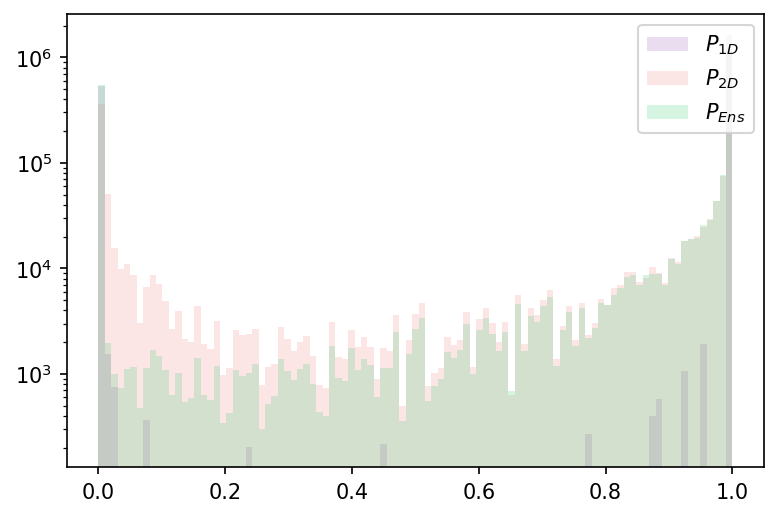

In [15]:
plt.figure(dpi=150)
plt.hist(Prob_1D_predictions[:,0], histtype="stepfilled", alpha=0.2, bins=np.linspace(0,1,100), label="$P_{1D}$")
plt.hist(Prob_2D_predictions[:,0], histtype="stepfilled", alpha=0.2, bins=np.linspace(0,1,100), label="$P_{2D}$")
plt.hist(Ensemble_Prob_predictions[:,0], histtype="stepfilled", alpha=0.2, bins=np.linspace(0,1,100), label="$P_{Ens}$")

plt.yscale("log")
plt.legend()


### Plot Probs

/tmp/ipykernel_248491/3476092000.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Prob_1D_false_e),1-Prob_1D_true_e, label="$P_{1D}$")#, c="cornflowerblue")
/tmp/ipykernel_248491/3476092000.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Prob_2D_false_e),1-Prob_2D_true_e, label="$P_{2D}$")
/tmp/ipykernel_248491/3476092000.py:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Prob_Ens_false_e),1-Prob_Ens_true_e, label="$P_{Ens}$")
/tmp/ipykernel_248491/3476092000.py:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-cl_pi_rej),cl_true_e, label="1D $N_{PE}$ Cut")#, c="darkorange")


[]

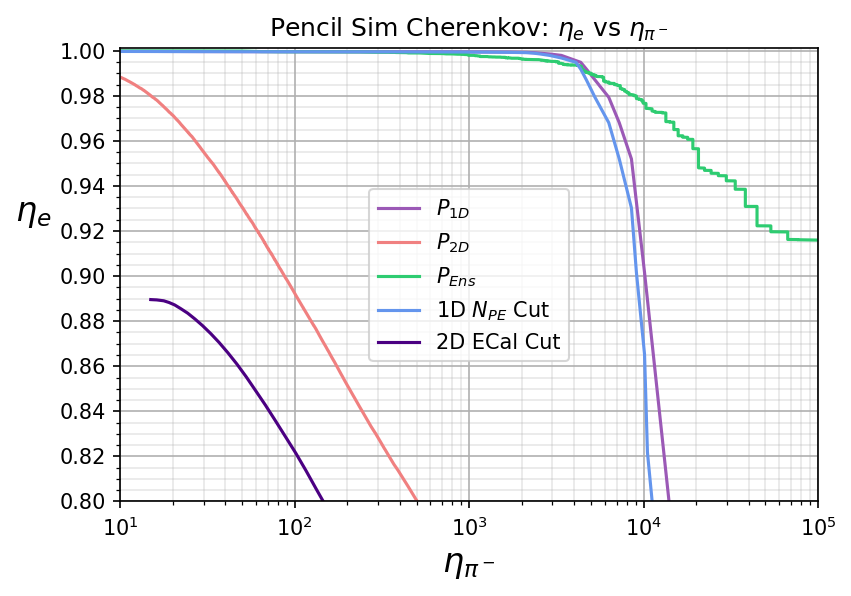

In [37]:
fig, ax = plt.subplots(dpi=150)
plt.title("Pencil Sim Cherenkov: $\eta_e$ vs $\eta_{\pi^-}$")#$\pi^-$ Rejection")
plt.ylabel("$\eta_e$",rotation=0, fontsize=16)
ax.yaxis.set_label_coords(-.125, .6)
#plt.xlabel("$\pi^-$ Rejection")
plt.xlabel("$\eta_{\pi^-}$", fontsize=16)

#plt.plot(1/(1-baseline_false_e),1-baseline_true_e, label="baseline", c="#9b59b6")
#plt.scatter(1/(1-MLP_NPE_false_e),1-MLP_NPE_true_e, label="MLP")#, c="cornflowerblue")
plt.plot(1/(1-Prob_1D_false_e),1-Prob_1D_true_e, label="$P_{1D}$")#, c="cornflowerblue")
plt.plot(1/(1-Prob_2D_false_e),1-Prob_2D_true_e, label="$P_{2D}$")
plt.plot(1/(1-Prob_Ens_false_e),1-Prob_Ens_true_e, label="$P_{Ens}$")

#plt.plot(1/(1-CNN_false_e),1-CNN_true_e, label="CNN")#, c="#2ecc71")
#plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Both", c="#9b59b6")
plt.plot(1/(1-cl_pi_rej),cl_true_e, label="1D $N_{PE}$ Cut")#, c="darkorange")
plt.plot(1/(1-eff_df["Pion Rejection"]),eff_df["Electron Efficiency"], label="2D ECal Cut")
#plt.plot(1/(1-baseline_false_e_part2),1-baseline_true_e_part2, c="green", alpha=.4)

#plt.plot(1/(1-GeV8_false_e),1-GeV8_true_e, label="GeV(6,8]", c="darkorange")
#plt.plot(1/(1-GeV10_false_e),1-GeV10_true_e, label="GeV(8,10]", c="fuchsia")
#plt.plot(1/(1-GeV12_false_e),1-GeV12_true_e, label="GeV(10,12]", c="saddlebrown")


#plt.vlines(0.95, .6,.1, color="firebrick", label="95% $Bkg_{rej}$") #label="95% $\pi^-_{rej}$")
#plt.plot([0.6,.1], [.95,.95], c="coral", label="95% $e_{eff}$")
#plt.scatter(50,.9, marker="*",s=150,c="magenta",zorder=100,label="ECal PCDR")

#plt.plot([0,1],[1,0])

#get handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
#order = [2,4,0,1,3,5,6]

#add legend to plot
plt.legend()#[handles[idx] for idx in order],[labels[idx] for idx in order])

#ax.set_xticks(np.arange(0,501,25), minor=1)
ax.set_yticks(np.arange(0.5,1.1,.02))
ax.set_yticks(np.arange(0.5,1.1,.005), minor=1)

plt.xlim(1e1,1e5)#(test_labels==1).sum())#1e6)
plt.ylim(0.8,1.001)

plt.xscale("log")
#plt.yscale("log")

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)

#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_TS3_Prob_v2.pdf")

plt.plot()